# **회귀 모델링 실습 1: 단일 층으로 이루어진 회귀 모델**


## **1. 환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) device 준비

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


### (3) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [10]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [6]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정
    for x, y in dataloader:     # batch : 현재 배치 번호, (x, y) : 입력 데이터와 레이블
        x, y = x.to(device), y.to(device)           # 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 연결

        # Feed Forward
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [7]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [8]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **2. 데이터 전처리**

### (1) 데이터 로딩 및 준비

In [11]:
# 데이터 로딩
path = 'https://bit.ly/ds_boston_csv'
data = pd.read_csv(path)

# x, y 분할
target = 'medv'
x = data.drop(target, axis = 1) # 이번에는 12개의 입력변수 모두를 이용합니다.
y = data.loc[:, target]

# train, val 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 데이터 로더

In [ ]:
# y_train, y_val을 넘파이 배열로 변환
y_train = y_train.values
y_val = y_val.values

# 데이터 로더 준비
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

## **3. 모델링**

### (1) 모델 구조 설계

In [12]:
n_feature = x.shape[1]
model2 = nn.Sequential(nn.Linear(n_feature, 2),
                       nn.ReLU(),
                       nn.Linear(2, 1)
                       ).to(device)

### (2) 학습

In [13]:
# 손실 함수, 옵티마이저 준비
loss_fn = nn.MSELoss()
optimizer = Adam(model2.parameters(), lr=0.01)

# 학습
epochs = 100 # 100번 반복 학습
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model2, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device)
    tr_loss_list.append(tr_loss) # learning curve 그리기 위해 리스트에 추가
    val_loss_list.append(val_loss) # learning curve 그리기 위해 리스트에 추가
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 559.819580, val loss : 472.402893
Epoch 2, train loss : 531.601013, val loss : 439.687073
Epoch 3, train loss : 491.021698, val loss : 399.568054
Epoch 4, train loss : 439.625366, val loss : 353.441406
Epoch 5, train loss : 392.671265, val loss : 304.557404
Epoch 6, train loss : 337.947937, val loss : 255.619064
Epoch 7, train loss : 287.004517, val loss : 211.255096
Epoch 8, train loss : 244.199860, val loss : 174.688202
Epoch 9, train loss : 208.660156, val loss : 148.582245
Epoch 10, train loss : 183.144760, val loss : 131.590240
Epoch 11, train loss : 170.140732, val loss : 120.880936
Epoch 12, train loss : 154.255188, val loss : 113.930260
Epoch 13, train loss : 145.638321, val loss : 108.791092
Epoch 14, train loss : 138.621658, val loss : 104.009232
Epoch 15, train loss : 134.022797, val loss : 99.226639
Epoch 16, train loss : 127.151123, val loss : 94.719337
Epoch 17, train loss : 120.662827, val loss : 90.388527
Epoch 18, train loss : 115.607391, val loss

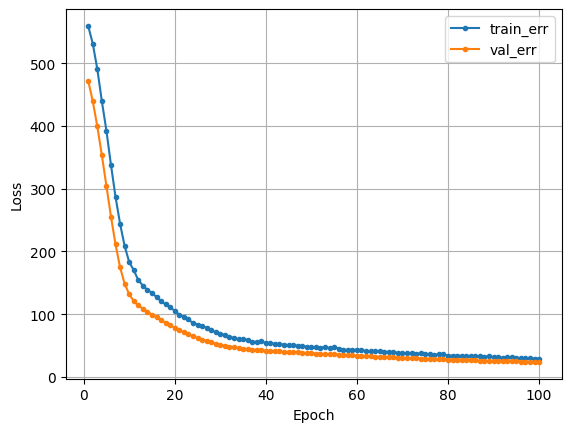

In [14]:
# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 예측 및 검증 평가

In [16]:
# 예측 결과
_, pred = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device)

# 모델 평가
mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

MAE : 3.8269102573394775
MAPE : 0.19562019407749176
